In [1]:
#!nvidia-smi


# ResNet 18

### Gender Classification

In [2]:
# IMPORT LIBRARY

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import drive
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# EKSTRASI DATASET

img_path = '/content/drive/MyDrive/Image Class_CelebA/'   # Lokasi path foto di g drive
img_dir = os.path.join(img_path, 'Images')    # direktori path foto ke folder Images
label_path = os.path.join(img_path, 'gender_class.csv')   # menggabungkan path foto dengan label

# Custom Dataset
class GenderDataset(Dataset):
    def __init__(self, label_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(label_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
# DATA TRANSFORMASI
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),    # augmentasi
        transforms.Resize((224, 224)),        # augmentasi
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # data normaliasi
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# membuat dataset
img_dataset = GenderDataset(label_path, img_dir, transform=data_transforms['train'])

# Split dataset
train_size = int(0.8 * len(img_dataset))    # ukuran data pelatihan
val_size = len(img_dataset) - train_size    # ukuran data validasi
train_dataset, val_dataset = torch.utils.data.random_split(img_dataset, [train_size, val_size])

val_dataset.dataset.transform = data_transforms['val']

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Mengatur penggunaan GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
n_feature = model.fc.in_features
model.fc = nn.Linear(n_feature, 1)  # Binary classification
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()    # Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)    # Optimizer

# Training
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = (torch.sigmoid(outputs) > 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                val_acc_history.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

# Train the model
model, train_acc_history, val_acc_history = train_model(model, criterion, optimizer, num_epochs=10)
print("Training Model successfully.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 0.1870 Acc: 0.9225


In [6]:
def model_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions
val_preds, val_labels = model_predictions(model, dataloaders['val'])


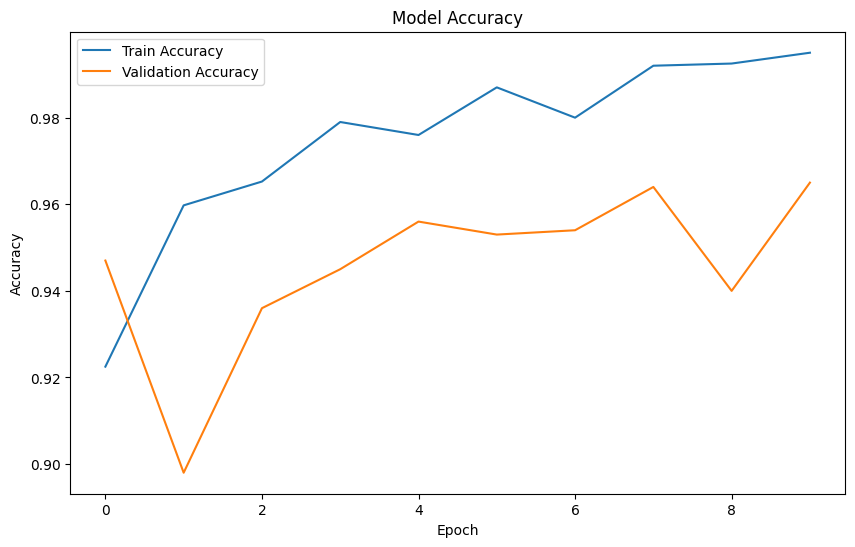

In [7]:
# Visualisasi akurasi training dan validasi
plt.figure(figsize=(10, 6))
plt.plot([h.cpu() for h in train_acc_history], label='Train Accuracy')
plt.plot([h.cpu() for h in val_acc_history], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

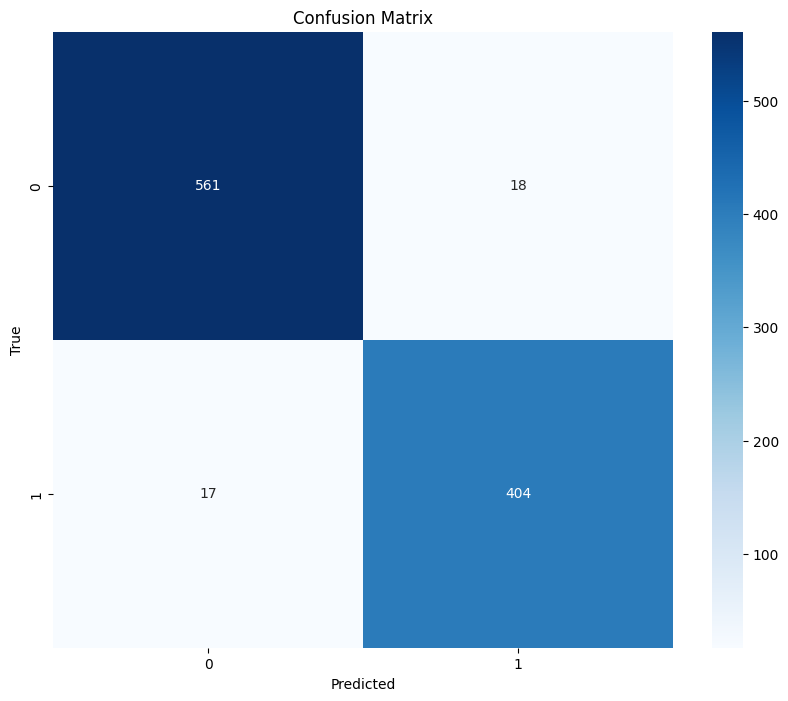

Classification Report:
              precision    recall  f1-score   support

      Female       0.97      0.97      0.97       579
        Male       0.96      0.96      0.96       421

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.97      0.96      0.97      1000



In [8]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['Female', 'Male']))

In [9]:
# Menyimpan Model
#torch.save(model.state_dict(), os.path.join(base_path, 'gender_classification01_resnet18.pth'))